In [14]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import os
import glob

In [15]:
base_path = "/volatile/ad279118/Irene/MOSTEST/Results/Imaging_Genetics/25irene_AD_CINGULATE_val/results/ChampollionV0"
#region_model = "/ChampollionV0/SFint-FCMant_right/trained_on_UKB40/16-55-54_1"
#region_model = "/ChampollionV0/CINGULATE_right/09-52-22_75"

region_model = "CINGULATE_left/09-35-58_201/white.British.ancestry"


From the variable base_path, the files must then be ordered as:

```
SFint-FCMant_left
└── trained_on_UKB40
    └── 16-55-54_0
        ├── Correlation_Matrix_SNPs_MOSTest.eps
        ├── extracted_genotypes.raw
        ├── mostest_imputed_autosomes_decim_maf-0.05.most_orig.sumstats
        ├── mostest_imputed_autosomes_decim_maf-0.05_most_orig.zmat.tsv
        └── pheno_pre_residualized.txt
```

In [16]:
pre_residualized_bdd = pd.read_csv(f'{base_path}/{region_model}/pheno_pre_residualized.txt', sep='\t')
z_score = pd.read_csv(f'{base_path}/{region_model}/mostest_imputed_autosomes_decim_maf-0.05_most_orig.zmat.tsv', sep='\t')

pre_residualized_bdd = pre_residualized_bdd.drop('#FID', axis=1)
pre_residualized_bdd = pre_residualized_bdd.set_index('IID')

In [17]:
path_to_lead_SNPs = glob.glob(f'{base_path}/{region_model}/FUMA/leadSNPs.txt')[0]
FUMA_lead_SNP = pd.read_csv(path_to_lead_SNPs, sep='\t', index_col=0)
FUMA_lead_SNP

,GenomicLocus,uniqID,rsID,chr,pos,p,nIndSigSNPs,IndSigSNPs
No,,,,,,,,
1,1,2:65977863:C:T,rs2009778,2,65977863,5.266481e-15,3,rs2009778;rs10176894;rs3815606
2,2,3:52572447:A:G,rs6445528,3,52572447,4.640306e-10,1,rs6445528
3,3,6:126868567:C:T,rs58321169,6,126868567,8.256084e-10,1,rs58321169
4,4,7:2766383:A:G,rs798536,7,2766383,1.287195e-09,1,rs798536
5,5,9:95934431:C:T,rs34739795,9,95934431,2.742762e-08,1,rs34739795
6,6,10:62052544:C:G,rs10740020,10,62052544,7.469744e-11,2,rs10740020;rs7073658
7,7,12:65905126:C:T,rs79487293,12,65905126,2.132814e-10,1,rs79487293
8,8,12:80019427:C:T,rs4842267,12,80019427,2.583931e-08,1,rs4842267
9,9,17:27938424:C:T,rs11080107,17,27938424,1.989898e-09,1,rs11080107


In [18]:
print(pre_residualized_bdd.shape)
pre_residualized_bdd = pre_residualized_bdd[[f'dim{i}' for i in range(1,pre_residualized_bdd.shape[1]+1)]]
pre_residualized_bdd.iloc[:,:5].head()

(36000, 42)


,dim1,dim2,dim3,dim4,dim5
IID,,,,,
1000021,1.434545,-0.641676,-0.626184,-0.264183,0.219514
1000325,0.062253,1.042469,-1.203298,1.157735,-0.431606
1000458,-1.083382,-0.876004,-1.157191,-0.327626,0.457972
1000575,-1.770864,-0.197241,0.454804,-0.207688,-0.167435
1000606,-0.530362,0.251658,1.927059,-0.733688,-1.463592


### To find a direction in the latent space, using Z-scores or regression

In [19]:
print(z_score.shape)
z_score = z_score[['CHR','SNP','PVAL', 'N', 'FREQ']+[f'dim{i}' for i in range(1,pre_residualized_bdd.shape[1]+1)]]
z_score.iloc[:,:8].head()

(150, 47)


,CHR,SNP,PVAL,N,FREQ,dim1,dim2,dim3
0,2,rs10176894,8.939456e-10,34123.0,0.394192,3.906821,0.052458,1.143224
1,2,rs1030088,1.043265e-09,35497.0,0.397132,3.521071,-0.043528,1.316289
2,2,rs12614005,9.446341e-09,35363.0,0.402059,3.494596,0.107599,1.196306
3,2,rs1541606,1.887125e-12,35489.0,0.420384,3.904114,-1.137603,1.350371
4,2,rs11893410,2.247522e-08,35491.0,0.392649,3.359917,0.112610,1.409810


In [20]:
def project(direction, latent=pre_residualized_bdd):
    # Compute the dot product of each row in pre_residualized_bdd with the direction
    dot_products = latent.apply(lambda row: np.dot(row, direction), axis=1)


    direction = np.dot(direction, direction)
    projections = dot_products / direction

    # Sort the series by the projection values
    sorted_projections = projections.sort_values(ascending=False)

    return sorted_projections

In [21]:
genotype = pd.read_csv(f'{base_path}/{region_model}/extracted_genotypes.raw', sep='\t')
genotype.head()

,FID,IID,PAT,MAT,SEX,PHENOTYPE,rs2009778_T,rs6445528_G,rs58321169_T,rs798536_A,rs34739795_T,rs10740020_G,rs79487293_T,rs4842267_C,rs11080107_C,rs12951057_G
0,1000021,1000021,0,0,1,-9,2.0,0.0,0.0,0.0,1.0,0.0,1,2.0,2,NaN
1,1000325,1000325,0,0,1,-9,1.0,1.0,1.0,1.0,0.0,1.0,0,1.0,1,0.0
2,1000458,1000458,0,0,1,-9,0.0,2.0,1.0,0.0,0.0,2.0,1,2.0,2,0.0
3,1000575,1000575,0,0,1,-9,1.0,1.0,0.0,1.0,1.0,2.0,1,1.0,2,0.0
4,1000606,1000606,0,0,2,-9,2.0,1.0,1.0,2.0,0.0,2.0,1,1.0,1,2.0


In [22]:
genotype[['IID','SEX','rs2009778_T']].head()

,IID,SEX,rs2009778_T
0,1000021,1,2.0
1,1000325,1,1.0
2,1000458,1,0.0
3,1000575,1,1.0
4,1000606,2,2.0


In [23]:
def save_projection_file(SELECTED_SNP, sorted_projections_df, heuristic):
    """
    SELECTED_SNP: str
        for instance 'rs3020595_G' or 'rs3020595'

    sorted_projections_df: df
        ['IID', 'projection'] are the two columns
    """

    folder_path = f'{base_path}/{region_model}/Sorted_projection/{heuristic}'
    # Ensure the folder exists
    os.makedirs(folder_path, exist_ok=True)

    # Define the full path to the CSV file
    csv_path = os.path.join(folder_path, f'{SELECTED_SNP}.csv')
    sorted_projections_df.set_index('IID', inplace=True)
    sorted_projections_df.to_csv(csv_path)

rs2009778_T 

R-squared (uncentered): 0.0012744301118806645
Prob (F-statistic): 0.45216491050098995 

Number of subject with 0 allele T: 5287
Number of subject with 1 allele T: 15694
Number of subject with 2 allele T: 12318


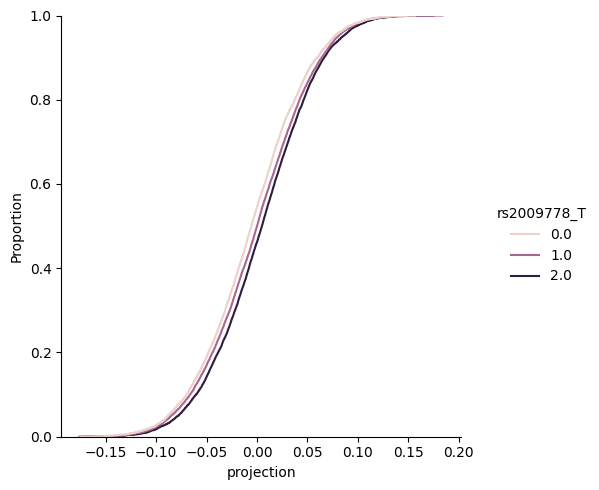

rs6445528_G 

R-squared (uncentered): 0.0014557184603285478
Prob (F-statistic): 0.22805115086807748 

Number of subject with 0 allele G: 9344
Number of subject with 1 allele G: 16574
Number of subject with 2 allele G: 7381


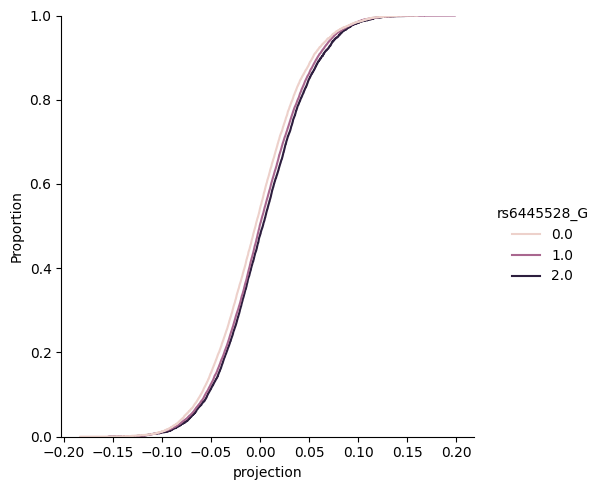

rs58321169_T 

R-squared (uncentered): 0.0021586106833839658
Prob (F-statistic): 0.0027546352286781923 

Number of subject with 0 allele T: 17966
Number of subject with 1 allele T: 12965
Number of subject with 2 allele T: 2368


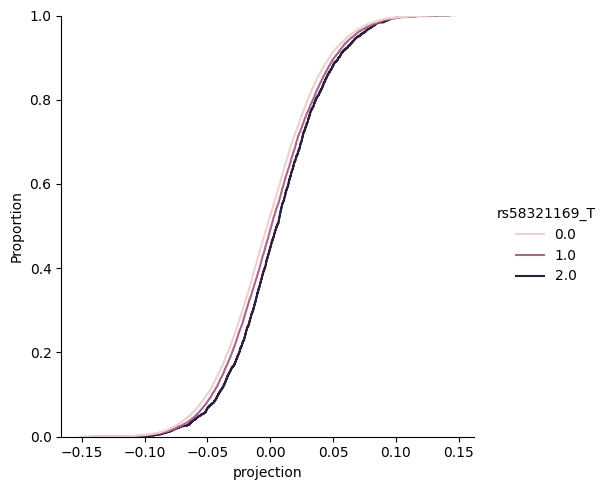

rs798536_A 

R-squared (uncentered): 0.0018729739961143022
Prob (F-statistic): 0.022147487255467765 

Number of subject with 0 allele A: 16253
Number of subject with 1 allele A: 14045
Number of subject with 2 allele A: 3001


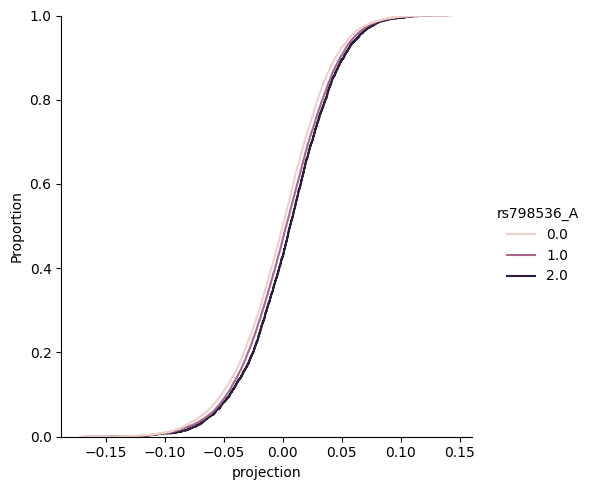

rs34739795_T 

R-squared (uncentered): 0.0022993544726761517
Prob (F-statistic): 0.0008780728990393618 

Number of subject with 0 allele T: 24513
Number of subject with 1 allele T: 8096
Number of subject with 2 allele T: 690


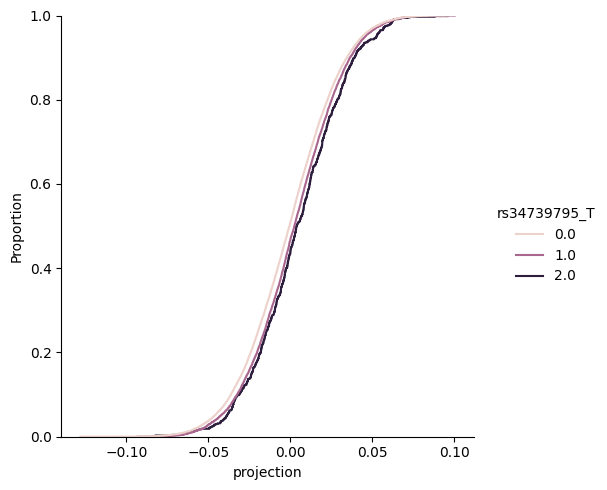

rs10740020_G 

R-squared (uncentered): 0.0008931960422767782
Prob (F-statistic): 0.9224237421165767 

Number of subject with 0 allele G: 5056
Number of subject with 1 allele G: 15808
Number of subject with 2 allele G: 12435


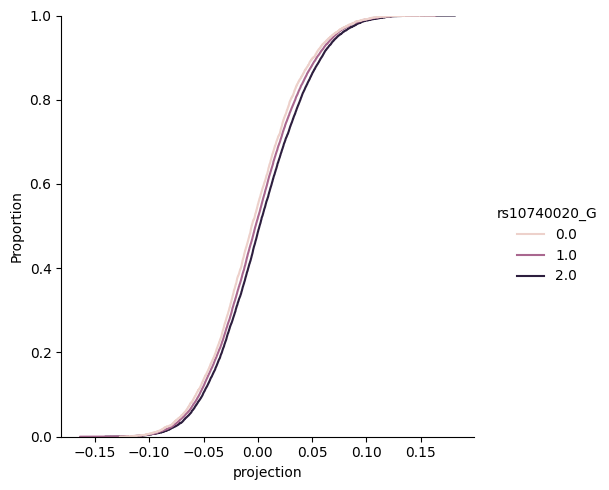

rs79487293_T 

R-squared (uncentered): 0.002090732623328706
Prob (F-statistic): 0.004659082993152231 

Number of subject with 0 allele T: 15018
Number of subject with 1 allele T: 14772
Number of subject with 2 allele T: 3509


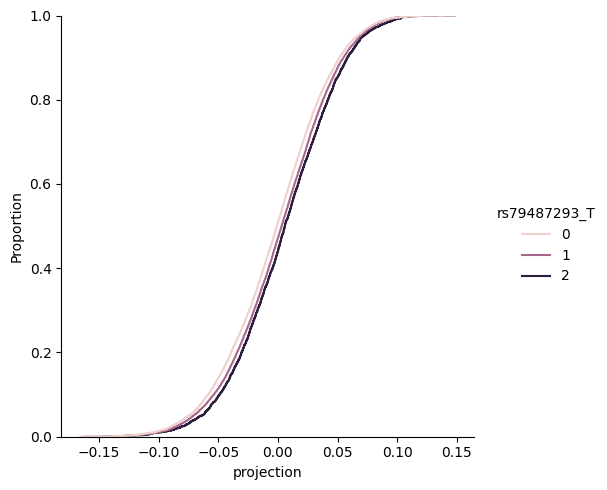

rs4842267_C 

R-squared (uncentered): 0.0005047735885981286
Prob (F-statistic): 0.9998194876591744 

Number of subject with 0 allele C: 2956
Number of subject with 1 allele C: 14024
Number of subject with 2 allele C: 16319


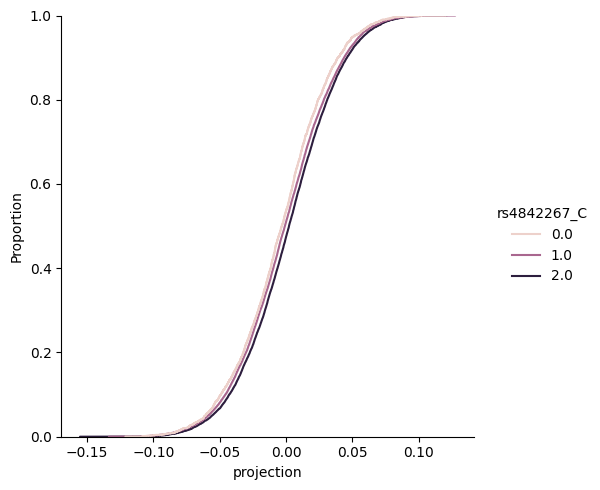

rs11080107_C 

R-squared (uncentered): 0.0013794284847453708
Prob (F-statistic): 0.31246073380398115 

Number of subject with 0 allele C: 8689
Number of subject with 1 allele C: 16856
Number of subject with 2 allele C: 7754


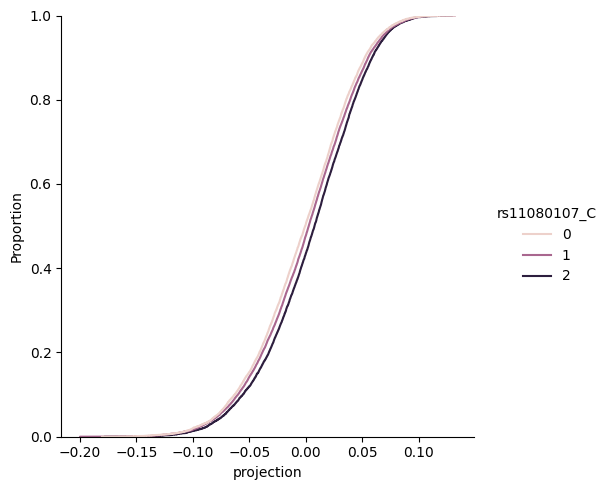

rs12951057_G 

R-squared (uncentered): 0.0024515309297273857
Prob (F-statistic): 0.00023679606661909536 

Number of subject with 0 allele G: 23084
Number of subject with 1 allele G: 9323
Number of subject with 2 allele G: 892


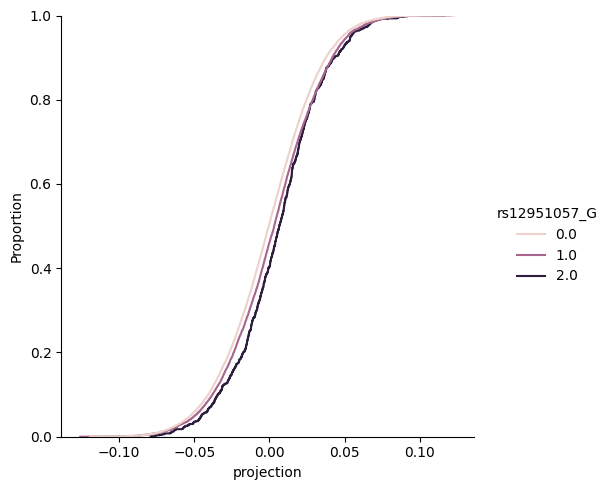

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import softmax

heuristic = "regression_on_latent" #"direction_square_Z_score" "direction_soft_max" "direction_Z_score" "regression_on_latent"
depending_on_SEX = False
violin = False
density = True

    #for the regression
bdd_geno = pd.merge(pre_residualized_bdd, genotype, on='IID', how='inner')
bdd_geno = bdd_geno.dropna()

# Features (latent dimensions) and target (genotype)
X = bdd_geno[[f'dim{i}' for i in range(1,pre_residualized_bdd.shape[1]+1)]]  # Select all latent dimensions

#SELECTED_SNP = "rs10917502"
for SELECTED_SNP in genotype.drop(['FID', 'IID', 'PAT', 'MAT', 'SEX', 'PHENOTYPE'], axis=1).keys():
    print(SELECTED_SNP, "\n")
    speci_Z = z_score[z_score.SNP==SELECTED_SNP[:-2]][[f'dim{i}' for i in range(1,pre_residualized_bdd.shape[1]+1)]]

    
    if heuristic == "direction_square_Z_score":
        direction = np.sign(speci_Z)*speci_Z**2
    elif heuristic == "direction_soft_max":
        direction = np.sign(speci_Z)*softmax(speci_Z)
    elif heuristic == "regression_on_latent":
        y = bdd_geno[SELECTED_SNP]         # Genotype values (0, 1, or 2)

        mod = sm.OLS(y, X)
        res = mod.fit()
        #print(res.summary())
        print("R-squared (uncentered):", res.rsquared)
        print("Prob (F-statistic):", res.f_pvalue, "\n")
        merged = pd.DataFrame({"IID":bdd_geno.IID, SELECTED_SNP:y,"projection":res.predict()}).sort_values('projection')
        save_projection_file(SELECTED_SNP, merged[['IID', 'projection']], heuristic)

    else:
        heuristic = "direction_Z_score"
        direction = speci_Z

    if heuristic != "regression_on_latent":

        direction = direction.to_numpy().flatten()

        sorted_projections = project(direction, pre_residualized_bdd)
        sorted_projections.name = 'projection'
        sorted_projections_df = sorted_projections.reset_index()
        sorted_projections_df.columns = ['IID', 'projection']

        selected_columns = genotype.loc[:, genotype.columns.str.startswith(SELECTED_SNP)]
        rsids = [rsid for rsid in selected_columns.columns]
        reduced_genotype = genotype[['IID', 'SEX']+rsids]

        merged = pd.merge(sorted_projections, reduced_genotype, on='IID', how='inner')
        merged = merged.dropna()

        save_projection_file(SELECTED_SNP, sorted_projections_df, heuristic)

    #print("10 first extreme cases", "\n", merged.iloc[0:10], "\n")
    #print("10 last extreme cases", "\n",merged.iloc[-10:], "\n")
    print(f"Number of subject with 0 allele {SELECTED_SNP[-1]}:", len(merged[merged[SELECTED_SNP]==0]))
    print(f"Number of subject with 1 allele {SELECTED_SNP[-1]}:", len(merged[merged[SELECTED_SNP]==1]))
    print(f"Number of subject with 2 allele {SELECTED_SNP[-1]}:", len(merged[merged[SELECTED_SNP]==2]))
    
    if violin :
        if depending_on_SEX:

            geno_pheno_male = merged[merged.SEX==1]
            geno_pheno_female = merged[merged.SEX==2]

            plt.figure(figsize=(8, 6))
            sns.violinplot(x=rsids[0], y='projection', data=geno_pheno_male, hue=SELECTED_SNP)

            plt.xlabel('Number of G Alleles')
            plt.ylabel('Projection Value')
            plt.title(f'Violin Plot of Projection vs. Number of {SELECTED_SNP} Alleles for males')
            plt.legend(loc='upper right')
            plt.show()

            plt.figure(figsize=(8, 6))
            sns.violinplot(x=rsids[0], y='projection', data=geno_pheno_female, hue=SELECTED_SNP)

            plt.xlabel('Number of G Alleles')
            plt.ylabel('Projection Value')
            plt.title(f'Violin Plot of Projection vs. Number of {SELECTED_SNP} Alleles for females')
            plt.legend(loc='upper right')
            plt.show()

        else:          
            plt.figure(figsize=(8, 6))
            sns.violinplot(x=rsids[0], y='projection', data=merged, hue=SELECTED_SNP)

            plt.xlabel('Number of G Alleles')
            plt.ylabel('Projection Value')
            plt.title(f'Violin Plot of Projection vs. Number of {SELECTED_SNP} Alleles')
            plt.legend(loc='upper right')
            plt.show()
    
    if density:
        sns.displot(data=merged, x="projection", kind="ecdf", hue=SELECTED_SNP)
        plt.show()






 

#### Compare the different approaches

In [51]:
folder_path = glob.glob(f'{base_path}/{region_model}/Sorted_projection/*')
folder_path

['/volatile/ad279118/Irene/MOSTEST/Results/Imaging_Genetics/25irene_AD_CINGULATE_val/results/ChampollionV0/CINGULATE_left/09-35-58_201/white.British.ancestry/Sorted_projection/direction_square_Z_score',
 '/volatile/ad279118/Irene/MOSTEST/Results/Imaging_Genetics/25irene_AD_CINGULATE_val/results/ChampollionV0/CINGULATE_left/09-35-58_201/white.British.ancestry/Sorted_projection/regression_on_latent']

In [55]:
for file in glob.glob(os.path.join(folder_path[0], '*')):
    if file.endswith('.csv'):
        #print(os.path.basename(file))
        path_0 = os.path.join(folder_path[0], os.path.basename(file))
        path_1 = os.path.join(folder_path[1], os.path.basename(file))

        ordered_pheno_0 = pd.read_csv(path_0)
        ordered_pheno_1 = pd.read_csv(path_1)
        
        print(path_0)
        print(path_1, "\n")

        merged_ordered_pheno = pd.merge(ordered_pheno_0, ordered_pheno_1, on='IID')
        merged_ordered_pheno = merged_ordered_pheno.drop('IID', axis=1)
        print(merged_ordered_pheno.corr(), "\n")



/volatile/ad279118/Irene/MOSTEST/Results/Imaging_Genetics/25irene_AD_CINGULATE_val/results/ChampollionV0/CINGULATE_left/09-35-58_201/white.British.ancestry/Sorted_projection/direction_square_Z_score/rs34739795_T.csv
/volatile/ad279118/Irene/MOSTEST/Results/Imaging_Genetics/25irene_AD_CINGULATE_val/results/ChampollionV0/CINGULATE_left/09-35-58_201/white.British.ancestry/Sorted_projection/regression_on_latent/rs34739795_T.csv 

              projection_x  projection_y
projection_x      1.000000     -0.935758
projection_y     -0.935758      1.000000 

/volatile/ad279118/Irene/MOSTEST/Results/Imaging_Genetics/25irene_AD_CINGULATE_val/results/ChampollionV0/CINGULATE_left/09-35-58_201/white.British.ancestry/Sorted_projection/direction_square_Z_score/rs10740020_G.csv
/volatile/ad279118/Irene/MOSTEST/Results/Imaging_Genetics/25irene_AD_CINGULATE_val/results/ChampollionV0/CINGULATE_left/09-35-58_201/white.British.ancestry/Sorted_projection/regression_on_latent/rs10740020_G.csv 

              p

### Keep only the subjects in the middle of the Gaussien distribution before applying the moving average (so as to compare similar shapes)

In [92]:
from scipy.spatial import distance
from scipy.spatial.distance import squareform

In [115]:
path_to_sorted_pheno = "/volatile/ad279118/Irene/MOSTEST/Results/Imaging_Genetics/25irene_AD_CINGULATE_val/results/ChampollionV0/CINGULATE_left/09-35-58_201/white.British.ancestry/Sorted_projection/regression_on_latent/rs4842267_C.csv"

In [116]:
latent_space = bdd_geno[['IID']+[f'dim{i}' for i in range(1,pre_residualized_bdd.shape[1]+1)]]
sorted_pheno = pd.read_csv(path_to_sorted_pheno)
latent_pheno = pd.merge(latent_space, sorted_pheno, on='IID')
latent_pheno = latent_pheno.sort_values(by='projection')
latent_pheno

,IID,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,...,dim34,dim35,dim36,dim37,dim38,dim39,dim40,dim41,dim42,projection
12872,2948423,0.535980,0.096411,-0.064346,1.684509,-3.662260,0.343168,0.129136,0.081241,0.492350,...,2.405759,-1.338961,1.183570,0.149174,0.357457,-1.590130,-1.382360,-0.211746,-1.930190,-0.155360
15834,3401792,0.357382,-0.331890,-0.362137,1.621730,-1.814975,1.833354,-0.588255,0.447789,0.458591,...,-0.134474,-0.668601,-0.701263,-0.365931,-0.496283,0.500935,-3.148895,0.522125,-2.431709,-0.134723
24759,4741853,0.219228,0.714952,-1.305420,0.875085,-3.934606,0.880510,-0.215379,-0.029840,0.338298,...,1.851986,0.205341,0.315235,-0.808013,-0.184902,2.354898,-0.462617,0.294228,-1.182869,-0.133617
18606,3816649,1.782677,-0.853037,-0.479578,-1.477137,-1.860566,-0.392267,-0.661218,0.567602,0.368463,...,0.085504,-0.650427,0.898192,-0.326524,0.318456,-0.278269,0.593644,0.795912,-1.751170,-0.130246
6007,1908139,0.018487,-0.281383,-1.496270,1.267512,-2.356014,1.620694,-0.703847,-0.770084,-0.622207,...,0.647934,2.070381,-0.679174,0.719184,-0.355676,0.553588,-2.680050,0.149948,0.779296,-0.123342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31275,5724379,-0.888954,0.397913,0.150652,-0.353970,0.677859,0.943734,1.276739,-1.721617,1.341525,...,0.084316,-0.058487,1.693204,-0.695310,0.449637,0.198022,2.460843,-0.548401,-0.522364,0.118451
22457,4400926,-2.031597,0.659833,-0.774118,-0.266202,2.147544,0.687087,0.412653,-1.358674,0.743566,...,-1.251963,-0.188658,0.832282,-1.744116,-2.462283,0.293865,-0.133771,-0.411743,-0.218515,0.118843
15245,3309734,0.604392,-1.031620,-1.065770,-0.051792,1.536043,0.301872,0.801659,-0.860071,-1.026772,...,-1.166352,0.585691,1.874907,0.489365,-0.145724,-0.202995,1.065770,0.447096,-0.072093,0.120545
22510,4408940,-0.625422,-0.021830,-0.374506,-0.447866,2.190718,0.423976,0.747427,-0.533731,1.106331,...,-1.019018,1.866892,1.216179,-1.667212,-0.524281,2.040450,-0.636382,-0.933997,-0.051304,0.120887


In [151]:
def small_10_percent_indexes(arr):
    # Find indexes where values fall within the 10% smallest distances
    indexes = np.where((arr <= np.percentile(arr, 10)))[0]
    return indexes.tolist()


In [153]:
step = 200
list_index = []
for i in range(0,pre_residualized_bdd.shape[0],step):
    sample = latent_pheno.drop(['IID', 'projection'], axis=1)
    sample = sample.iloc[i:i+step,:] 
    if len(sample)==step:
        list_dist = distance.pdist(sample, 'cosine')# 'sqeuclidean')
        square_form_dist = squareform(list_dist)
        mean_dist = np.mean(square_form_dist, axis=0)
        indexes = small_10_percent_indexes(mean_dist)
        list_index.extend(indexes)
        #plt.hist(mean_dist)
        #plt.show()


In [160]:
directory = os.path.dirname(path_to_sorted_pheno)
latent_pheno.iloc[list_index,:][['IID', 'projection']].to_csv(os.path.join(directory, 'rs4842267_C_small_distances.csv'), index=False)

In [112]:
#len(list_dist)
'''
m is the number of vectors we are working with (number of subjects in the latent space)
for i < j < m
dist(u=X[i], v=X[j])
is given at position
m * i + j - ((i + 2) * (i + 1)) // 2
'''
#m = len(latent_space)
#i = 1120
#j = 20000
#print(distance.pdist([latent_space.drop('IID', axis=1).iloc[i],latent_space.drop('IID', axis=1).iloc[j]], 'cosine')[0])
#print(list_dist[m * i + j - ((i + 2) * (i + 1)) // 2])

'\nm is the number of vectors we are working with (number of subjects in the latent space)\nfor i < j < m\ndist(u=X[i], v=X[j])\nis given at position\nm * i + j - ((i + 2) * (i + 1)) // 2\n'